# Causal Inference in Statistics: A Primer

In [3]:
import numpy as np
import pandas as pd
import graphviz as gv
import ipywidgets as pw

### 1.2.2

> A baseball batter Tim has a better batting average than his teammate Frank. However, someone notices that Frank has a better batting average than Tim against both right-handed and left-handed pitchers. How can this happen?

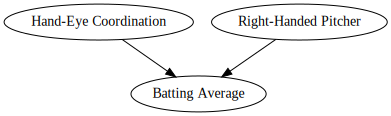

In [2]:
batter: gv.Digraph = gv.Digraph("batter", comment="Comparison of Batting Averages")
batter.node("H", "Hand-Eye Coordination")
batter.node("P", "Right-Handed Pitcher")
batter.node("B", "Batting Average")
batter.edges(["HB", "PB"])
batter

In [30]:
def bat_avg(right_prop: float, right_avg: float, left_avg: float) -> float:
    left_prop: float = 1 - right_prop
    avg: float = (left_prop * left_avg) + (right_prop * right_avg)
    return avg
    
def bat_avg_summary(
    frank_right_prop: float,
    frank_right_avg: float,
    frank_left_avg: float,
    tim_right_prop: float,
    tim_right_avg: float,
    tim_left_avg: float
) -> pd.DataFrame:
    frank_total: float = bat_avg(frank_right_prop, frank_right_avg, frank_left_avg)
    tim_total: float = bat_avg(tim_right_prop, tim_right_avg, tim_left_avg)
    df: pd.DataFrame = pd.DataFrame({
        "Frank": [frank_left_avg, frank_right_avg, frank_total],
        "Tim": [tim_left_avg, tim_right_avg, tim_total]
    }, index=["Left", "Right", "Total"])
    display(df)
    return df

frp: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
fra: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
fla: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
trp: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
tra: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
tla: pw.FloatSlider = pw.FloatSlider(min=0., max=1., step=.001, style={"description_width": "initial"})
bat_ia: pw.interactive = pw.interactive(
    bat_avg_summary,
    frank_right_prop=frp,
    frank_right_avg=fra,
    frank_left_avg=fla,
    tim_right_prop=trp,
    tim_right_avg=tra,
    tim_left_avg=tla
)

display(bat_ia)

interactive(children=(FloatSlider(value=0.0, description='frank_right_prop', max=1.0, step=0.001, style=Slider…

### 1.3.2 

Consider the following table:

In [31]:
t1_5: pd.DataFrame = pd.DataFrame({
    "Gender": ["Male", "Male", "Male", "Male", "Female", "Female", "Female", "Female"],
    "Highest_Ed": ["< HS", "HS", "Univ", "Grad", "< HS", "HS", "Univ", "Grad"],
    "Occurrence": [112, 231, 595, 242, 136, 189, 763, 172]
})

t1_5

,Gender,Highest_Ed,Occurrence
0,Male,< HS,112
1,Male,HS,231
2,Male,Univ,595
3,Male,Grad,242
4,Female,< HS,136
5,Female,HS,189
6,Female,Univ,763
7,Female,Grad,172


Estimate the following:

+ P(HS)
+ P(HS OR Female)
+ P(HS | Female)
+ P(Female | HS)

In [46]:
def occurrence(rfilter: pd.Series, df: pd.DataFrame=t1_5, col: str = "Occurrence") -> int:
    return df[rfilter][col].sum()

def p_hs() -> float:
    numerator: int = occurrence(t1_5["Highest_Ed"] == "HS")
    denominator: int = t1_5["Occurrence"].sum()
    return float(numerator) / denominator


def p_hs_or_f() -> float:
    numerator: int = occurrence(t1_5["Highest_Ed"] == "HS") + occurrence(t1_5["Gender"] == "Female")
    denominator: int = t1_5["Occurrence"].sum()
    return float(numerator) / denominator


def p_hs_given_f() -> float:
    subset: pd.DataFrame = t1_5[t1_5["Gender"] == "Female"]
    numerator: int = occurrence(subset["Highest_Ed"] == "HS", df=subset)
    denominator: int = subset["Occurrence"].sum()
    return float(numerator) / denominator


def p_f_given_hs() -> float:
    subset: pd.DataFrame = t1_5[t1_5["Highest_Ed"] == "HS"]
    numerator: int = occurrence(subset["Gender"] == "Female", df=subset)
    denominator: int = subset["Occurrence"].sum()
    return float(numerator) / denominator
    
t1_5_probs: str = f"""
P(HS) = {p_hs()}
P(HS OR Female) = {p_hs_or_f()}
P(HS | Female) = {p_hs_given_f()}
P(Female | HS) = {p_f_given_hs()}
"""
print(t1_5_probs)


P(HS) = 0.1721311475409836
P(HS OR Female) = 0.6885245901639344
P(HS | Female) = 0.15
P(Female | HS) = 0.45



### 1.3.5 (Monty Hall)

> Suppose you are on the Monty Hall show, and you are looking to win a car. You have three doors to choose from. Two of them have goats behind them while the other has a car. You first choose a door, and then Monty Hall actually opens one of the remaining doors. He will never reveal the car, so you see a goat. You are then given a choice. Does it make sense to stick with your original door, or switch the last remaining door?

If we label the doors A, B, and C, suppose we chose door A and Monty opened door C to reveal a goat. Our question is whether or not A or B is more likely to have the car. If P(A) > P(B), we should stay with A, and if P(B) > P(A), we should switch. If P(A) == P(B), it doesn't really matter what we do, so let's set the problem up as though it does matter (i.e. an inequality is in play). We do have some context, so what we really want to understand is the following relation:

$$P(X=A, Y=B, Z=C) > P(X=A, Y=A, Z=C)$$

Note that the A, B, C are the doors, while X is our choice event, Y is the location of the car event, and Z is Monty's choice event. The key is to recognize when information is provided. 

**Stage 0**

At the outset, we know the car is behind one of the doors, but have no idea which. With maximum uncertainty, all options have the same probability:

$$P(Y=A)= P(Y=B) = P(Y=C) = \frac{1}{3}$$

**Stage 1**

We then make our move, choosing door A. However, this move ($X=A$) doesn't really change our understanding of where the car is, because the car choice did not depend on our choice in any way. There is no causal linkage.

$$P(Y=A | X=A)= P(Y=B | X=A) = P(Y=C | X=A) = \frac{1}{3}$$

**Stage 2**

A new player enters the chat. Monty makes his move, selecting door C ($Z=C$). Crucially, Monty is constrained in this choice. He can't choose our door, A, and he can't choose a door that would reveal the car. In other words, his choice is causally bound by the previous events.

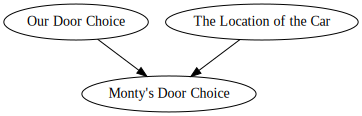

In [47]:
monty: gv.Digraph = gv.Digraph("monty", comment="Monty Hall's Door Choice")
monty.node("X", "Our Door Choice")
monty.node("Y", "The Location of the Car")
monty.node("Z", "Monty's Door Choice")
monty.edges(["XZ", "YZ"])
monty

Now we have a way to reason about the entire joint probability. Recall that all of the following are equivalent:

$$P(X, Y, Z) = P(X|Y,Z)P(Y|Z)P(Z) = P(Y|X,Z)P(X|Z)P(Z) = P(Z|X,Y)P(Y|X)P(X) = \dots$$

There are many such breakdowns. That can represent the same joint probability. Our goal is to choose one that helps us fill gaps in what we observe. As the diagram above makes clear, only one of the breakdowns we have shown above speaks directly to the causal elements of Monty's choice:

$$P(Z|X,Y)P(Y|X)P(X)$$

And we can reason directly about the rightmost terms. We chose door A, so at stage 1, X is known: $P(X=A | X=A) = 1$. We know our door choice did not affect the location of the car, so $P(Y=A|X=A) = P(Y=B|X=A) = P(Y=C|X=A) = \frac{1}{3}$. Now we just need to understand $P(Z|X,Y)$. There are only so many ways this could go.

In [48]:
monty_df: pd.DataFrame = pd.DataFrame({
    "X": ["A", "A", "A", "A"],
    "Y": ["A", "A", "B", "C"],
    "Z": ["B", "C", "C", "B"]
})

monty_df

,X,Y,Z
0,A,A,B
1,A,A,C
2,A,B,C
3,A,C,B


If we choose the door with the car, Monty has a choice of the other two doors.

$$P(Z=B|X=A,Y=A) = P(Z=B|X=A,Y=A) = \frac{1}{2}$$

If we don't choose the door with the car, Monty *must* reveal the location of the car.

$$P(Z=B|X=A,Y=C) = P(Z=C|X=A,Y=B) = 1$$

In [49]:
monty_df["P(Z|X,Y)"] = [0.5, 0.5, 1, 1]
monty_df

,X,Y,Z,"P(Z|X,Y)"
0,A,A,B,0.5
1,A,A,C,0.5
2,A,B,C,1.0
3,A,C,B,1.0


The only other insight is to note that we aren't choosing between A, B, and C, but rather between A (our choice) and B or C (not our choice). Whether or not the car is actually behind door B or C is irrelevant, so long as it is not A. Now we can put it all together:

$$P(Z=B|X=A,Y=A)P(Y=A|X=A)P(X=A|X=A) = (\frac{1}{2}) (\frac{1}{3})(1) = \frac{1}{6}$$
$$P(Z=C|X=A,Y=A)P(Y=A|X=A)P(X=A|X=A) = (\frac{1}{2}) (\frac{1}{3})(1) = \frac{1}{6}$$
$$P(Z=C|X=A,Y=B)P(Y=B|X=A)P(X=A|X=A) = (1) (\frac{1}{3})(1) = \frac{1}{3}$$
$$P(Z=B|X=A,Y=C)P(Y=C|X=A)P(X=A|X=A) = (1) (\frac{1}{3})(1) = \frac{1}{3}$$

If we add up the cases when $Y=A$ we get a total of $\frac{1}{3}$. If we add up the cases when $Y=\not A$, we get ... $\frac{2}{3}$ (gasp)! In other words, $P(X=A, Y=\not A, Z=\not A) = \frac{2}{3} > P(X=A, Y=A, Z=\not A) = \frac{1}{3}$. From a tactical standpoint, we should always switch doors when Monty offers.